### Pre-process the Data

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
import random

In [3]:
def random_brightness(img, factor):
    # assume input is color image
    # convert Red, Green, Blue to Hue, Saturation, Value
    # factor describes the range of brightness scaling: (1 - factor, 1 + factor)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    bright_factor = random.uniform(1. - factor, 1. + factor)
    print("brightness", bright_factor)
    img_hsv = np.array(img_hsv, np.float)
    img_hsv[:,:,2] = np.minimum(255, img_hsv[:,:,2] * bright_factor)
    img_hsv = np.array(img_hsv, dtype = np.uint8)
    img_new = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    
    return img_new

In [4]:
def xy_translation(img, steer, dfactor):
    # assume input is color image
    # dfactor is the fraction of total pixels as translation range
    ncol, nrow, nch = img.shape
    tX = dfactor * ncol * random.uniform(-1., 1.)
    tY = dfactor * 0.3 * nrow * random.uniform(-1., 1.) # give vertical translation less freedom
    print("right shift =", tX)
    print("down shift =", tY)
    Mtrans = np.float32([[1,0,tX], [0,1,tY]])
    img_new = cv2.warpAffine(img, Mtrans,(nrow, ncol))
    steer_new = steer + tX * .004
    return img_new, steer_new

right shift = -8.643631382382274
down shift = 0.4651332574288474
right shift = -1.9572381430403567
down shift = 10.246207244394531
right shift = -20.631075223608235
down shift = 5.140504651502996
right shift = -22.587552258810348
down shift = 0.19426555556353406
right shift = 28.44190217900516
down shift = 5.025189675644714
right shift = 26.550101002571452
down shift = -13.892744731346639
right shift = -9.62035670103974
down shift = -14.49055208206482
right shift = -6.420267191197588
down shift = -14.032084450647327
right shift = -2.9034881772672563
down shift = 16.991864570177732


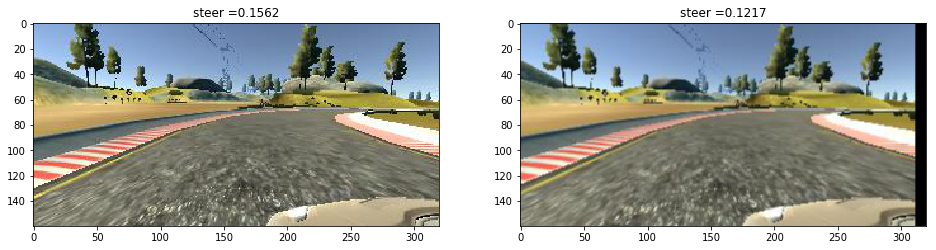

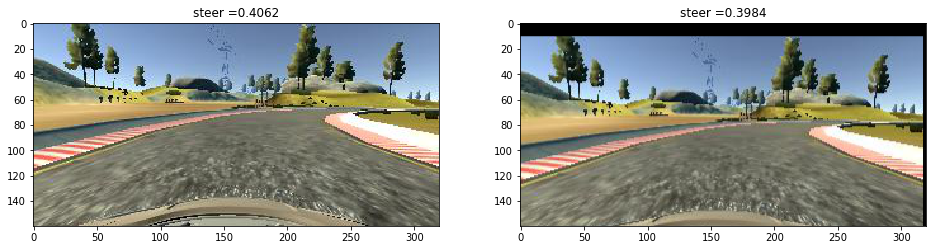

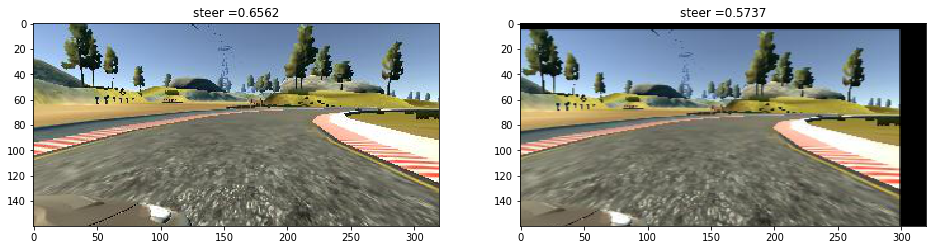

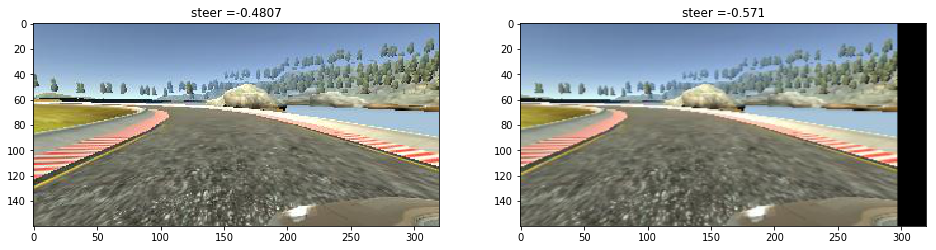

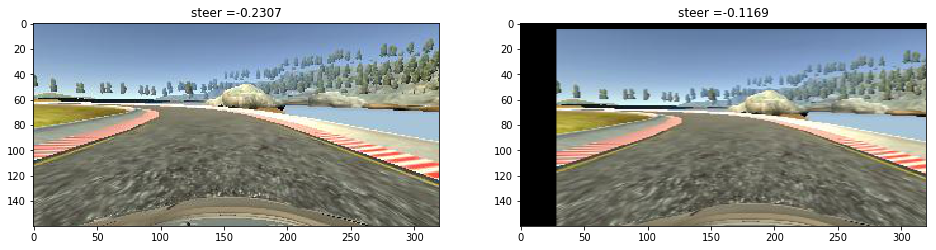

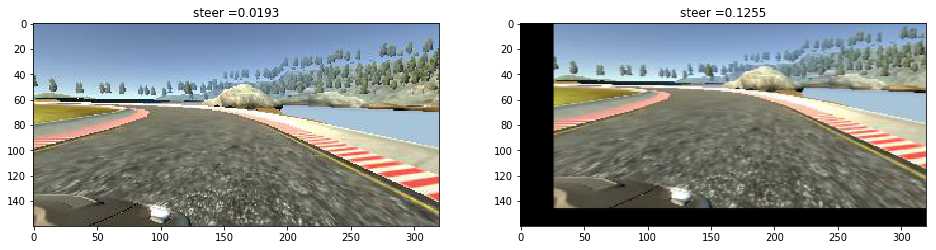

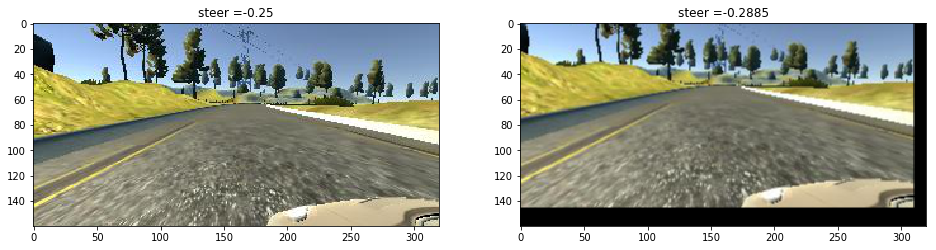

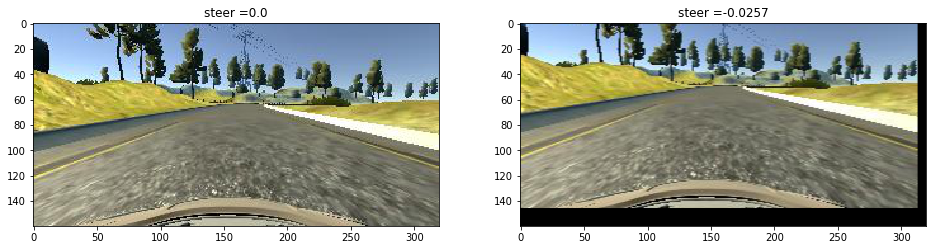

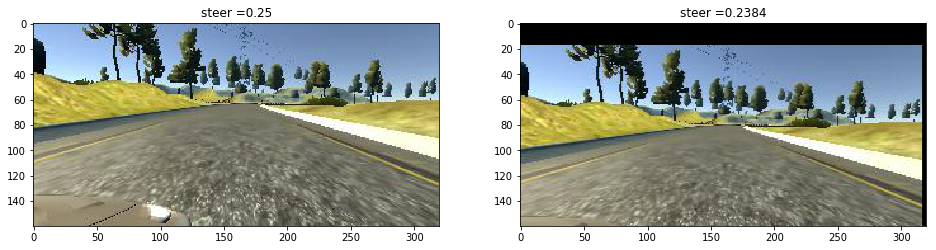

In [8]:
path = './data/IMG/'
#filenames = ['center_2016_12_01_13_33_45_217.jpg', 'center_2016_12_01_13_33_54_272.jpg', 'center_2016_12_01_13_33_59_244.jpg']
#filenames = ['center_2016_12_01_13_33_45_217.jpg', 'center_2016_12_01_13_33_54_272.jpg']
filenames = ['_2016_12_01_13_33_45_217.jpg', '_2016_12_01_13_33_54_272.jpg', '_2016_12_01_13_33_59_244.jpg']
steer = [0.406227, -0.2306556, 0]
#steer = [0.406227, -0.406227, -0.2306556, 0.2306556]
#steer = [0.406227, -0.2306556]
camera_pos = ['left', 'center', 'right']
steer_correct = [-0.25, 0., 0.25]
images = []
for i in range(3):
    for j in range(3):
        file_name = camera_pos[j] + filenames[i]
        file_path = path + file_name
        this_steer = steer[i] + steer_correct[j]
        img = cv2.imread(file_path) #cv2 read in images as BGR (not RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #fl_img = cv2.flip(img, 1)
        #br_img = random_brightness(img, 0.7)
        tr_img, steer_new = xy_translation(img, this_steer, 0.2)
        #print(img.shape)
    
        fig, ax = plt.subplots(ncols = 2, figsize = (16,9))
        ax[0].set_title('steer =' + str(np.round(this_steer, 4)))
        ax[0].imshow(img)
        #ax[1].imshow(fl_img)
        #ax[1].imshow(br_img)
        ax[1].imshow(tr_img)
        ax[1].set_title('steer =' + str(np.round(steer_new, 4)))
    
        images.append(img)
        #images.append(fl_img)    #1 means flip around y-axis

In [26]:
# convert to numpy arrays for Keras
X_train = np.array(images)
y_train = np.array(steer)

In [27]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D


In [28]:
model = Sequential()
model.add(Lambda(lambda x : x/255. - 0.5, input_shape = (160, 320, 3)))
#model.add(Cropping2D(cropping = ((70, 25), (0, 0))))
# 3 @ 1x1 filter to choose color space automatically
model.add(Convolution2D(3, 1, 1, init = 'he_normal', activation = 'elu', border_mode = 'valid', name = 'conv0'))
#
model.add(Convolution2D(24, 5, 5, init = 'he_normal', subsample = (2, 2), border_mode = 'valid', activation = 'elu', name = 'conv1'))
model.add(Convolution2D(36, 5, 5, init = 'he_normal', subsample = (2, 2), border_mode = 'valid', activation = 'elu', name = 'conv2'))
model.add(Convolution2D(48, 5, 5, init = 'he_normal', subsample = (2, 2), border_mode = 'valid', activation = 'elu', name = 'conv3'))
model.add(Convolution2D(64, 3, 3, init = 'he_normal', subsample = (1, 1), border_mode = 'valid', activation = 'elu', name = 'conv4'))
model.add(Convolution2D(64, 3, 3, init = 'he_normal', subsample = (1, 1), border_mode = 'valid', activation = 'elu', name = 'conv5'))
model.add(Flatten())
model.add(Dense(100, init = 'he_normal', activation = 'elu', name = 'full1'))
model.add(Dense(50, init = 'he_normal', activation = 'elu', name = 'full2'))
model.add(Dense(10, init = 'he_normal', activation = 'elu', name = 'full3'))
model.add(Dense(1, init = 'he_normal', name = 'full4'))

In [29]:
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, nb_epoch = 50) #, validation_split = 0.2, shuffle = True
y_pred = model.predict(X_train)
print(y_pred)

model.save('model.h5')

Epoch 1/50
4/4 [==============================] - 1s - loss: 0.9035
Epoch 2/50
4/4 [==============================] - 0s - loss: 226.0990
Epoch 3/50
4/4 [==============================] - 0s - loss: 14.6106
Epoch 4/50
4/4 [==============================] - 0s - loss: 1.8547
Epoch 5/50
4/4 [==============================] - 0s - loss: 4.1926
Epoch 6/50
4/4 [==============================] - 0s - loss: 2.8254
Epoch 7/50
4/4 [==============================] - 0s - loss: 0.2923
Epoch 8/50
4/4 [==============================] - 0s - loss: 1.7143
Epoch 9/50
4/4 [==============================] - 0s - loss: 6.4911
Epoch 10/50
4/4 [==============================] - 0s - loss: 14.8305
Epoch 11/50
4/4 [==============================] - 0s - loss: 5.2029
Epoch 12/50
4/4 [==============================] - 0s - loss: 0.4172
Epoch 13/50
4/4 [==============================] - 0s - loss: 0.5462
Epoch 14/50
4/4 [==============================] - 0s - loss: 0.6958
Epoch 15/50
4/4 [======================